Задание:
Выберите набор данных (датасет) для решения задачи прогнозирования временного ряда.
Визуализируйте временной ряд и его основные характеристики.
Разделите временной ряд на обучающую и тестовую выборку.
Произведите прогнозирование временного ряда с использованием как минимум двух методов.
Визуализируйте тестовую выборку и каждый из прогнозов.
Оцените качество прогноза в каждом случае с помощью метрик.

In [13]:
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
import warnings
warnings.filterwarnings('ignore')

In [14]:
data = pd.read_csv('rates.csv', sep=',')
data

,Date,United States(USD),Europe(EUR),Japan(JPY),United Kingdom(GBP),Canada(CAD),Switzerland(CHF),India(INR),China(CNY),Turkey(TRY),Saudi Arabia(SAR),Indonesia(IDR),United Arab Emirates(AED),Thailand(THB),Vietnam(VND),Egypt(EGP),South Korean(KRW),Australia(AUD),South Africa(ZAR)
0,31-01-1979,233.7,144.8,45160.3,117.4,267.1,379.3,1840.8,NaN,NaN,745.2,139739.3,856.1,4511.3,NaN,NaN,108235.8,197.2,194.5
1,28-02-1979,251.3,154.6,50209.1,124.2,295.5,413.6,2011.7,NaN,NaN,827.8,154683.1,946.6,4985.7,NaN,NaN,119929.3,219.6,209.4
2,30-03-1979,240.1,148.0,50274.3,116.2,278.2,406.2,1940.2,NaN,NaN,796.7,148844.2,910.4,4812.9,NaN,NaN,116123.6,214.6,202.4
3,30-04-1979,245.3,152.8,54144.6,118.8,278.5,420.0,2013.1,NaN,NaN,819.4,152453.6,930.2,4891.0,NaN,NaN,117423.3,221.1,206.9
4,31-05-1979,274.6,172.0,61057.1,132.7,321.6,478.0,2253.4,NaN,NaN,933.3,171656.1,1048.4,5560.8,NaN,NaN,133889.6,250.7,233.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,31-03-2021,1691.1,1438.8,186861.0,1225.7,2125.4,1591.5,123639.0,11084.8,13995.6,6342.1,24562502.0,6211.5,52845.3,39020979.9,26579.1,1913845.9,2220.3,24970.5
507,30-04-2021,1767.7,1468.4,193213.0,1276.7,2174.6,1612.2,130934.3,11439.4,14657.4,6628.9,25533702.8,6492.8,55040.2,40753168.5,27681.4,1966245.4,2288.4,25644.2
508,31-05-2021,1900.0,1554.0,207845.0,1336.6,2295.3,1708.7,137979.1,12084.8,16105.4,7125.4,27131285.3,6978.3,59344.9,43786246.6,29772.2,2110939.4,2454.6,26067.3
509,30-06-2021,1763.2,1486.8,195692.0,1276.3,2183.3,1629.8,131054.9,11392.5,15317.4,6612.5,25565673.6,6476.3,56509.0,40580658.2,27672.6,1985571.3,2348.5,25175.6


Предварительная обработка

Удаляем все столбцы, кроме даты и USD:

In [15]:
data = data[['Date','United States(USD)']]
for i, row in data.iterrows():
    data.at[i, 'Date'] = '01'+row['Date'][2:]
data

,Date,United States(USD)
0,01-01-1979,233.7
1,01-02-1979,251.3
2,01-03-1979,240.1
3,01-04-1979,245.3
4,01-05-1979,274.6
...,...,...
506,01-03-2021,1691.1
507,01-04-2021,1767.7
508,01-05-2021,1900.0
509,01-06-2021,1763.2


In [16]:
data = data.rename(columns={'Date': 'date'})
data = data.rename(columns={'United States(USD)': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')
data = data.set_index('date')
data = data.asfreq(freq ='MS')
data

,y
date,
1979-01-01,233.7
1979-02-01,251.3
1979-03-01,240.1
1979-04-01,245.3
1979-05-01,274.6
...,...
2021-03-01,1691.1
2021-04-01,1767.7
2021-05-01,1900.0


## Разделение выборки на обучающую и тестовую

                 y
date              
1979-01-01   233.7
1979-02-01   251.3
1979-03-01   240.1
1979-04-01   245.3
1979-05-01   274.6
...            ...
2021-03-01  1691.1
2021-04-01  1767.7
2021-05-01  1900.0
2021-06-01  1763.2
2021-07-01  1825.8

[511 rows x 1 columns]
Train dates : 1979-01-01 00:00:00 --- 2018-07-01 00:00:00  (n=475)
Test dates  : 2018-08-01 00:00:00 --- 2021-07-01 00:00:00  (n=36)


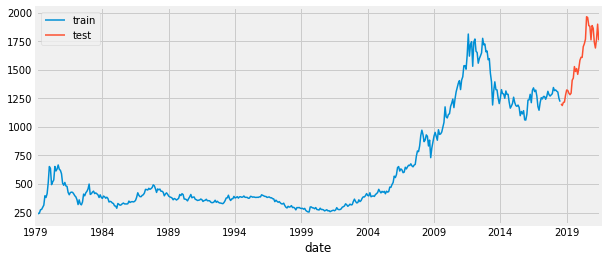

In [17]:
import matplotlib.pyplot as plt
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(data)

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score

def test_model(predictions):
    print('mean_absolute_error: {}'.format(round(mean_absolute_error(data_test['y'], predictions), 2)))
    print('median_absolute_error: {}'.format(round(median_absolute_error(data_test['y'], predictions), 2)))
    print('r2_score: {}'.format(round(r2_score(data_test['y'], predictions), 2)))

## Обучение моделей

### Skforecast-ForecasterAutoreg

In [19]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['y'])
steps = 36
predictions = forecaster.predict(steps=steps)


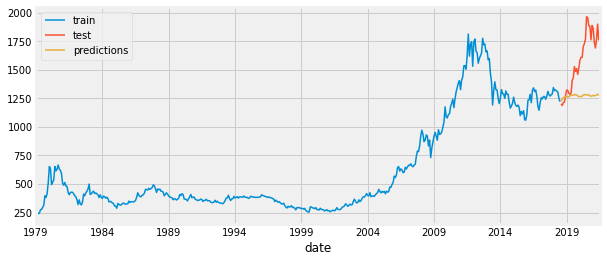

In [20]:
fig, ax2 = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax2, label='train')
data_test['y'].plot(ax=ax2, label='test')
predictions.plot(ax=ax2, label='predictions')
ax2.legend();

In [21]:
lags_grid = [10, 16]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )


Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:18<00:00, 39.30s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 44788.07209342369



mean_absolute_error: 330.55
median_absolute_error: 336.26
r2_score: -1.7


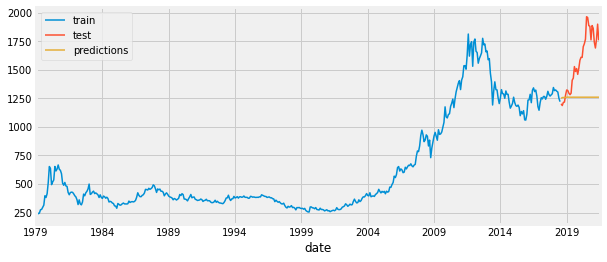

In [22]:
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 16
             )

forecaster.fit(y=data_train['y'])
predictions = forecaster.predict(steps=steps)
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
test_model(predictions)

### SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05869D+00    |proj g|=  1.10599D-01


 This problem is unconstrained.



At iterate    5    f=  5.01903D+00    |proj g|=  8.93625D-03

At iterate   10    f=  5.00965D+00    |proj g|=  5.11742D-02

At iterate   15    f=  4.98555D+00    |proj g|=  1.56510D-01

At iterate   20    f=  4.95426D+00    |proj g|=  2.15613D-01

At iterate   25    f=  4.94329D+00    |proj g|=  8.69678D-02

At iterate   30    f=  4.93441D+00    |proj g|=  2.59812D-01

At iterate   35    f=  4.93083D+00    |proj g|=  7.66407D-03

At iterate   40    f=  4.93081D+00    |proj g|=  8.39468D-03

At iterate   45    f=  4.93071D+00    |proj g|=  1.30219D-02

At iterate   50    f=  4.93060D+00    |proj g|=  8.28324D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

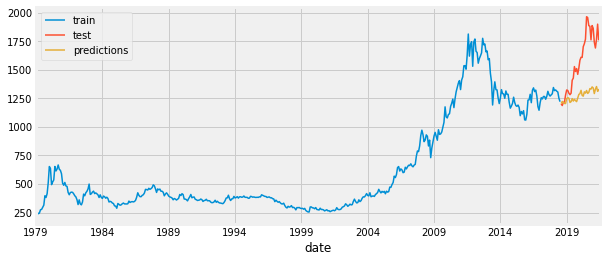

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

SARIMAXmodel = SARIMAX(data_train['y'], order = (3, 1, 3), seasonal_order=(3,1,5,22))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"]
fig, ax2 = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax2, label='train')
data_test['y'].plot(ax=ax2, label='test')
y_pred_out.plot(ax=ax2, label='predictions')
ax2.legend()
test_model(y_pred_out)